In [1]:
# Add this line at the beginning of the file
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
K = tf.keras.backend
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import Callback

Generated dataset shapes:
X_train shape: (1, 48, 128, 1)
y_train shape: (1, 5, 5)


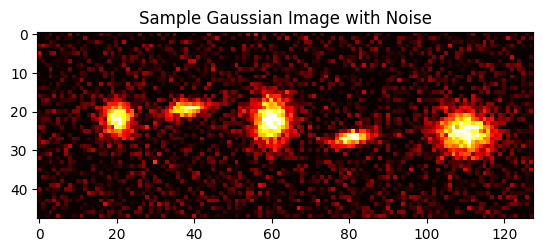

Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):
[[ 2.01934319e+01  2.19166698e+01  2.75318575e+00  2.95597577e+00
  -1.38481990e-01]
 [ 3.81439819e+01  1.92632618e+01  3.56895566e+00  1.42851686e+00
  -1.25097722e-01]
 [ 6.01780167e+01  2.21473560e+01  3.38411617e+00  4.44681931e+00
  -2.04416346e-02]
 [ 8.08615875e+01  2.67536526e+01  3.67977500e+00  1.32382715e+00
  -1.56082958e-01]
 [ 1.10352486e+02  2.54012623e+01  5.08644485e+00  3.85129523e+00
   4.41876799e-02]]


In [2]:
def generate_gaussian_blob(image_size, mean, cov, angle, noise_std=0.01):
    """
    Generate a single Gaussian blob on an image with added random noise.
    """
    x, y = np.meshgrid(np.linspace(0, image_size[0] - 1, image_size[0]),
                       np.linspace(0, image_size[1] - 1, image_size[1]))
    x -= mean[0]
    y -= mean[1]

    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)

    x_rot = cos_angle * x + sin_angle * y
    y_rot = -sin_angle * x + cos_angle * y

    exponent = (x_rot ** 2) / (2 * cov[0] ** 2) + (y_rot ** 2) / (2 * cov[1] ** 2)
    blob = np.exp(-exponent)

    # Add random noise centered around the Gaussian blob
    noise = np.random.normal(0, noise_std, blob.shape)
    blob += noise

    return blob

def convert_parameters(parameters):
    """
    Convert Gaussian parameters from (amplitude, x0, y0, sigma_x, sigma_y) to (mean_x, mean_y, cov_x, cov_y, theta).
    """
    A, x0, y0, sigma_x, sigma_y = parameters

    mean_x = x0
    mean_y = y0
    cov_x = sigma_x
    cov_y = sigma_y

    # Calculate theta from the covariance values
    if cov_x != 0 and cov_y != 0:
        theta = 0.5 * np.arctan2(2 * cov_x * cov_y, (cov_x**2 - cov_y**2))
    else:
        theta = 0.0

    return mean_x, mean_y, cov_x, cov_y, theta

def create_training_data(num_samples, image_size=(128, 48), num_blobs=5, noise_std=0.05):
    """
    Create training data with Gaussian blobs and noise for the YOLO-style model.
    """
    X = np.zeros((num_samples, image_size[1], image_size[0], 1), dtype=np.float32)
    y = np.zeros((num_samples, num_blobs, 5), dtype=np.float32)

    for i in range(num_samples):
        image = np.zeros((image_size[1], image_size[0]), dtype=np.float32)
        blob_params = []

        # Generate y-values within 20% of each other
        base_y = np.random.uniform(0.4 * image_size[1], 0.6 * image_size[1])
        y_values = np.random.uniform(base_y * 0.8, base_y * 1.2, num_blobs)

        # Generate evenly spaced x-values with slight variation
        x_values = np.linspace(0, image_size[0], num_blobs + 2)[1:-1]
        x_values += np.random.uniform(-5, 5, num_blobs)

        for j in range(num_blobs):
            mean_x = x_values[j]
            mean_y = y_values[j]
            cov_x = np.random.uniform(2, 6)
            cov_y = np.random.uniform(1, 5)
            theta = np.random.uniform(-10, 10) * np.pi / 180  # Cap rotation at 10 degrees

            blob = generate_gaussian_blob((image_size[0], image_size[1]), (mean_x, mean_y), (cov_x, cov_y), theta, noise_std)
            image += blob

            # Store parameters for the label
            blob_params.append((mean_x, mean_y, cov_x, cov_y, theta))

        # Convert parameters to labels
        for j in range(num_blobs):
            mean_x, mean_y, cov_x, cov_y, theta = blob_params[j]
            y[i, j, :] = [mean_x, mean_y, cov_x, cov_y, theta]

        X[i, :, :, 0] = np.clip(image, 0, 1)

    return X, y

num_samples = 1  # Number of training samples
X_train, y_train = create_training_data(num_samples, noise_std=0.05)

print("Generated dataset shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
plt.imshow(X_train[0].squeeze(), cmap='hot')
plt.title("Sample Gaussian Image with Noise")
plt.show()
print("Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):")
print(y_train[0])

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class CropLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(CropLayer, self).__init__(**kwargs)

    def call(self, inputs):
        image, crop_boxes = inputs
        batch_size = tf.shape(image)[0]
        num_boxes = tf.shape(crop_boxes)[1]
        crop_boxes = tf.reshape(crop_boxes, (batch_size * num_boxes, 4))  # Flatten the crop_boxes tensor
        box_indices = tf.range(batch_size)
        box_indices = tf.repeat(box_indices, repeats=num_boxes)
        img_size = tf.constant([48, 48], dtype=tf.int32)

        cropped_images = tf.image.crop_and_resize(
            image, crop_boxes, box_indices, img_size, method='bilinear',
            extrapolation_value=0.0,
        )

        return cropped_images

def build_cnn_with_gaussian_prediction(input_shape):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Initial convolutions to process the full image
    x = layers.Conv2D(8, kernel_size=3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Predict 5 crop areas
    crop_pred = layers.Conv2D(16, kernel_size=3, activation='relu', padding='same')(x)
    crop_pred = layers.Flatten()(crop_pred)
    crop_pred = layers.Dense(64, activation='relu')(crop_pred)
    crop_pred = layers.Dense(5 * 4, activation='sigmoid', name='crop_prediction')(crop_pred)

    # Reshape crop predictions to [batch_size, 5, 4] format
    crop_boxes = layers.Reshape((5, 4))(crop_pred)

    # Crop the original input image
    cropped_images = CropLayer()([inputs, crop_boxes])

    x = layers.Conv2D(6, kernel_size=3, strides=1, padding='same')(cropped_images)
    x = layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=4, strides=4)(x)

    x = layers.Conv2D(16, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(98, activation='relu')(x)
    x = layers.Dense(52, activation='relu')(x)
    outputs = layers.Dense(5)(x)

    model = Model(inputs=inputs, outputs=[outputs, crop_pred])
    return model

# Example usage
input_shape = (48, 128, 1)
model = build_cnn_with_gaussian_prediction(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 24, 64, 8)      │             80 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 12, 32, 8)      │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 6, 16, 16)      │          1,168 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 3, 8, 16)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 3, 8, 16)       │          2,320 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 384)            │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         24,640 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop_prediction (Dense)   │ (None, 20)             │          1,300 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 5, 4)           │              0 │ crop_prediction[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop_layer (CropLayer)    │ (None, 48, 48, 1)      │              0 │ input_layer[0][0],     │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 48, 48, 6)      │             60 │ crop_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 48, 48, 6)      │            192 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 48, 48, 6)      │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 12, 12, 6)      │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 12, 12, 16)     │            880 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 12, 12, 16)     │             48 │ conv2d_4[0][0]         │
│ (BatchNormalization) 

 Total params: 92,647 (361.90 KB)

 Trainable params: 92,527 (361.43 KB)

 Non-trainable params: 120 (480.00 B)

X_train shape: (800, 48, 128, 1)
y_train shape: (800, 5, 5)
X_val shape: (200, 48, 128, 1)
y_val shape: (200, 5, 5)


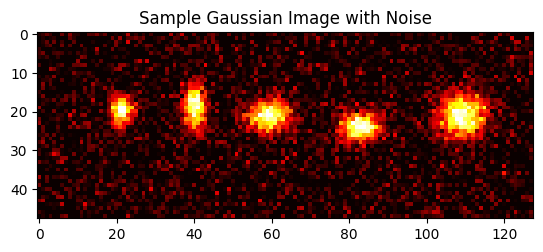

Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):
[[ 2.3033648e+01  2.4598392e+01  3.0434260e+00  3.6483648e+00
  -1.2817454e-01]
 [ 3.9736889e+01  2.6133001e+01  3.1016588e+00  4.3543482e+00
  -1.4220618e-01]
 [ 6.6021080e+01  2.0498663e+01  5.3987827e+00  1.4987515e+00
  -7.6222509e-02]
 [ 8.7352600e+01  2.5998892e+01  4.9451251e+00  4.8412676e+00
  -3.0337177e-02]
 [ 1.0875555e+02  2.4199503e+01  3.7438796e+00  2.4059510e+00
   1.0221856e-01]]


In [4]:
# Generate the training data
num_samples = 1000
X, y = create_training_data(num_samples)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 48, 128, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 128, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Visualize a sample image and its Gaussians
plt.imshow(X_train[0].squeeze(), cmap='hot')
plt.title("Sample Gaussian Image with Noise")
plt.show()

print("Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):")
print(y_val[0])

In [5]:
def gaussian_loss(y_true, y_pred):
    # Reshape y_true and y_pred to ensure compatibility
    y_true = tf.reshape(y_true, [-1, 5, 1])
    y_pred = tf.reshape(y_pred, [-1, 5, 1])

    # Separate the true and predicted parameters
    true_meanx, true_meany, true_covx, true_covy, true_theta = tf.split(y_true, 5, axis=1)
    pred_meanx, pred_meany, pred_covx, pred_covy, pred_theta = tf.split(y_pred, 5, axis=1)

    # Compute the Mean Squared Error for each parameter
    meanx_loss = tf.reduce_mean(tf.square(true_meanx - pred_meanx))
    meany_loss = tf.reduce_mean(tf.square(true_meany - pred_meany))
    covx_loss = tf.reduce_mean(tf.square(true_covx - pred_covx))
    covy_loss = tf.reduce_mean(tf.square(true_covy - pred_covy))
    theta_loss = tf.reduce_mean(tf.square(true_theta - pred_theta))

    # Weighted sum of the losses
    loss = meanx_loss + meany_loss + covx_loss + covy_loss + theta_loss

    return loss

In [6]:
model = build_cnn_with_gaussian_prediction(input_shape)

model.compile(optimizer='adam', loss = gaussian_loss)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node functional_1_1/crop_layer_1_1/CropAndResize defined at (most recent call last):
<stack traces unavailable>
Detected at node functional_1_1/crop_layer_1_1/CropAndResize defined at (most recent call last):
<stack traces unavailable>
Detected unsupported operations when trying to compile graph __inference_one_step_on_data_4740[] on XLA_GPU_JIT: CropAndResize (No registered 'CropAndResize' OpKernel for XLA_GPU_JIT devices compatible with node {{node functional_1_1/crop_layer_1_1/CropAndResize}}){{node functional_1_1/crop_layer_1_1/CropAndResize}}
The op is created at: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-6-7c703274703c>", line 6, in <cell line: 6>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 556, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "<ipython-input-3-5d7930b6edd2>", line 17, in call
	tf2xla conversion failed while converting __inference_one_step_on_data_4740[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_4903]

In [1]:
test_X, test_y = create_training_data(1)

NameError: name 'create_training_data' is not defined